In [21]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name!="/device:GPU:0":
  raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


In [22]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt

In [23]:
class ResidualUnit(keras.layers.Layer):
  def __init__(self,filters,strides=1,activation="relu",**kwargs):
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
                        keras.layers.Conv2D(filters,3,strides=strides,padding='same',use_bias=False),
                        keras.layers.BatchNormalization(),
                        self.activation,
                        keras.layers.Conv2D(filters,3,strides=1,padding="same",use_bias=False),
                        keras.layers.BatchNormalization()]
    self.skip_layers = []
    if strides > 1:
      self.skip_layers = [
                          keras.layers.Conv2D(filters,1,strides=strides,padding="same",use_bias=False),
                          keras.layers.BatchNormalization()]
  def call(self,inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
      skip_Z = inputs
      for layer in self.skip_layers:
        skip_Z = layer(skip_Z)
    return self.activation(Z+skip_Z)

In [24]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,7,strides=2,input_shape=[28,28,1],padding="same",use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same"))

prev_filters = 0
for filters in [64]*3+[128]*4+[256]*6+[512]*3:
  strides = 1 if filters==prev_filters else 2
  model.add(ResidualUnit(filters,strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10,activation="softmax"))

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_159 (Conv2D)          (None, 14, 14, 64)        3136      
_________________________________________________________________
batch_normalization_159 (Bat (None, 14, 14, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 4, 4, 64)          78592     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 4, 4, 64)          74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 4, 4, 64)         

In [26]:
(X_train_full,y_train_full),(X_test,y_test) = keras.datasets.fashion_mnist.load_data()
X_train,X_valid = X_train_full[:-5000],X_train_full[-5000:]
y_train,y_valid = y_train_full[:-5000],y_train_full[-5000:]
X_mean = X_train.mean(axis=0,keepdims=True)
X_std = X_train.std(axis=0,keepdims=True)+1e-7
X_train = (X_train-X_mean)/X_std
X_valid = (X_valid-X_mean)/X_std
X_test = (X_test-X_mean)/X_std
X_train = X_train[...,np.newaxis]
X_valid = X_valid[...,np.newaxis]
X_test = X_test[...,np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [27]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_valid,y_valid))
score = model.evaluate(X_test,y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 92s 49ms/step - loss: 0.8301 - accuracy: 0.7391 - val_loss: 0.4045 - val_accuracy: 0.8582
Epoch 2/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.4176 - accuracy: 0.8570 - val_loss: 0.3953 - val_accuracy: 0.8542
Epoch 3/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.3586 - accuracy: 0.8764 - val_loss: 0.4073 - val_accuracy: 0.8602
Epoch 4/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.3579 - accuracy: 0.8761 - val_loss: 0.2941 - val_accuracy: 0.8930
Epoch 5/10
1719/1719 [==============================] - 83s 48ms/step - loss: 0.3317 - accuracy: 0.8856 - val_loss: 0.2912 - val_accuracy: 0.8956
Epoch 6/10
1719/1719 [==============================] - 83s 49ms/step - loss: 0.3033 - accuracy: 0.8934 - val_loss: 0.2920 - val_accuracy: 0.8934
Epoch 7/10
1719/1719 [==============================] - 83s 49ms/step - loss: 0.2726 - accuracy: 0.9036 - val_loss: 0.2880 -

In [28]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [29]:
def visualize_data(images,categories,class_names):
  fig = plt.figure(figsize=(14,6))
  fig.patch.set_facecolor("white")
  for i in range(3*7):
    plt.subplot(3,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i])
    class_index = categories[i].argmax()
    plt.xlabel(class_names[class_index])
  plt.show()

In [30]:
class_names = ['airplane','automobile','bird','cat','deer',"dog",'frog','horse','ship','truck']
num_classes = len(class_names)
(x_train,y_train), (x_test,y_test) = cifar10.load_data()
x_train = x_train / 255.0
y_train = to_categorical(y_train,num_classes)

x_test = x_test/255.0
y_test=to_categorical(y_test,num_classes)

(50000, 32, 32, 3) (50000, 10)


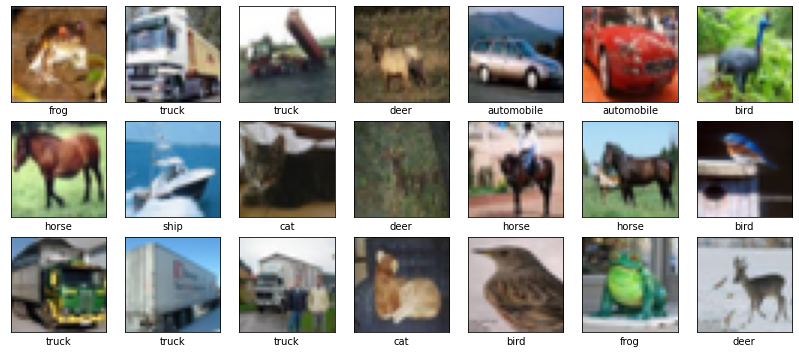

In [31]:
print(x_train.shape,y_train.shape)
visualize_data(x_train,y_train,class_names)

In [32]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,7,strides=2,input_shape=[32,32,3],padding="same",use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same"))
prev_filters = 0

for filters in [64]*3 +[128]*4 +[256]*6 +[512]*3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters,strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10,activation="softmax"))

In [33]:
model.compile(loss="categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])
history = model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
score = model.evaluate(x_test,y_test)

Epoch 1/10
1563/1563 [==============================] - 87s 51ms/step - loss: 1.9393 - accuracy: 0.3545 - val_loss: 2.3101 - val_accuracy: 0.2644
Epoch 2/10
1563/1563 [==============================] - 78s 50ms/step - loss: 1.2999 - accuracy: 0.5436 - val_loss: 1.7717 - val_accuracy: 0.4496
Epoch 3/10
1563/1563 [==============================] - 78s 50ms/step - loss: 1.0775 - accuracy: 0.6248 - val_loss: 1.4575 - val_accuracy: 0.4973
Epoch 4/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.9532 - accuracy: 0.6695 - val_loss: 1.5496 - val_accuracy: 0.4837
Epoch 5/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.9074 - accuracy: 0.6895 - val_loss: 1.1669 - val_accuracy: 0.6002
Epoch 6/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.7838 - accuracy: 0.7296 - val_loss: 1.0081 - val_accuracy: 0.6442
Epoch 7/10
1563/1563 [==============================] - 78s 50ms/step - loss: 0.6938 - accuracy: 0.7636 - val_loss: 0.8917 -

In [34]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

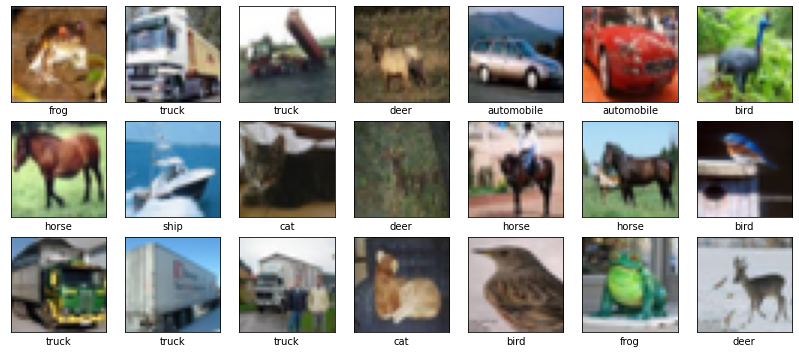

In [35]:
(x_train,y_train),(x_test,y_test) = cifar10.load_data()

x_train = x_train/255.0
y_train = to_categorical(y_train,num_classes)

x_test = x_test/255.0
y_test = to_categorical(y_test,num_classes)

visualize_data(x_train,y_train,class_names)

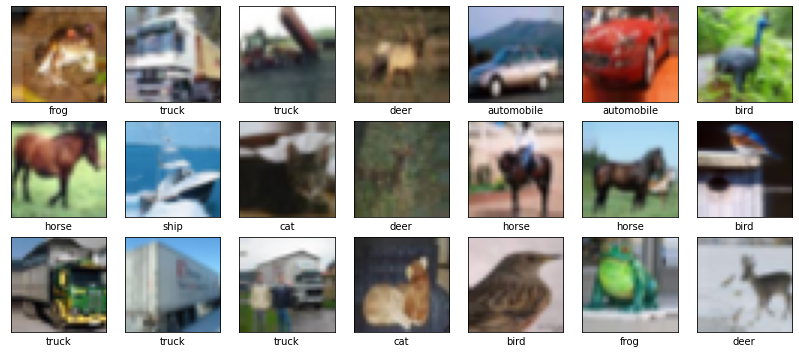

In [36]:
width_shift = 3/32
height_shift = 3/32
flip = True
datagen = ImageDataGenerator(
    horizontal_flip = flip,
    width_shift_range = width_shift,
    height_shift_range = height_shift
)
datagen.fit(x_train)
it = datagen.flow(x_train,y_train,shuffle=False)
batch_images, batch_labels = next(it)
visualize_data(batch_images,batch_labels,class_names)

In [37]:
train_datagen = ImageDataGenerator(horizontal_flip = flip,width_shift_range = width_shift,
                                   height_shift_range = height_shift)
valid_datagen = ImageDataGenerator(rescale=1)

train_generator = train_datagen.flow(x_train,y=y_train,batch_size=32)
valid_generator = valid_datagen.flow(x_test,y=y_test,batch_size=32)

In [38]:
model.compile(loss="categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])
history = model.fit(train_generator,epochs=10,validation_data=valid_generator)
score = model.evaluate(x_test,y_test)

Epoch 1/10
1563/1563 [==============================] - 94s 55ms/step - loss: 0.9258 - accuracy: 0.6848 - val_loss: 1.2670 - val_accuracy: 0.5569
Epoch 2/10
1563/1563 [==============================] - 84s 54ms/step - loss: 0.9311 - accuracy: 0.6789 - val_loss: 2.0576 - val_accuracy: 0.5559
Epoch 3/10
1563/1563 [==============================] - 85s 54ms/step - loss: 0.8715 - accuracy: 0.7041 - val_loss: 0.8726 - val_accuracy: 0.7018
Epoch 4/10
1563/1563 [==============================] - 85s 54ms/step - loss: 0.7456 - accuracy: 0.7420 - val_loss: 0.8738 - val_accuracy: 0.7249
Epoch 5/10
1563/1563 [==============================] - 85s 55ms/step - loss: 0.7346 - accuracy: 0.7447 - val_loss: 0.7369 - val_accuracy: 0.7455
Epoch 6/10
1563/1563 [==============================] - 85s 54ms/step - loss: 0.7031 - accuracy: 0.7573 - val_loss: 0.8971 - val_accuracy: 0.7083
Epoch 7/10
1563/1563 [==============================] - 86s 55ms/step - loss: 0.6859 - accuracy: 0.7626 - val_loss: 1.2520 -

In [39]:
class ResidualUnit50(keras.layers.Layer):
  def __init__(self,filters,strides=1,activation="relu",**kwargs):
    super().__init__(**kwargs)
    self.activation=keras.activations.get(activation)
    self.main_layers = [
                        keras.layers.Conv2D(filters,1,strides=strides,padding='same',use_bias=False),
                        keras.layers.BatchNormalization(),
                        self.activation,
                        keras.layers.Conv2D(filters,3,strides=1,padding="same",use_bias=False),
                        keras.layers.BatchNormalization(),
                        self.activation,
                        keras.layers.Conv2D(filters*4,1,strides=1,padding="same",use_bias=False),
                        keras.layers.BatchNormalization(),
                        self.activation
                        ]
    self.skip_layers = []
    if strides>1:
      self.skip_layers = [
                          keras.layers.Conv2D(filters*4,1,strides=strides,padding="same",use_bias=False),
                          keras.layers.BatchNormalization(),
                          ]
  def call(self,inputs):
    Z = inputs
    for layer in self.main_layers:
      Z = layer(Z)
      skip_Z = inputs
      for layer in self.skip_layers:
        skip_Z = layer(skip_Z)
    return self.activation(Z+skip_Z)

In [40]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,7,strides=2,input_shape=[32,32,3],padding="same",use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same"))

prev_filters = 0
for filters in [64]*3+[128]*4+[256]*6+[512]*3:
  strides = 1 if filters==prev_filters else 2
  model.add(ResidualUnit50(filters,strides=strides))
  prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10,activation="softmax"))

In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_233 (Conv2D)          (None, 16, 16, 64)        9408      
_________________________________________________________________
batch_normalization_233 (Bat (None, 16, 16, 64)        256       
_________________________________________________________________
activation_5 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
residual_unit50_48 (Residual (None, 4, 4, 256)         76288     
_________________________________________________________________
residual_unit50_49 (Residual (None, 4, 4, 256)         71168     
_________________________________________________________________
residual_unit50_50 (Residual (None, 4, 4, 256)        

In [42]:
model.compile(loss="categorical_crossentropy",optimizer="nadam",metrics=["accuracy"])
history = model.fit(train_generator,epochs=50,validation_data=valid_generator)
score = model.evaluate(x_test,y_test)

Epoch 1/50
1563/1563 [==============================] - 130s 76ms/step - loss: 2.7750 - accuracy: 0.2488 - val_loss: 2.9095 - val_accuracy: 0.2020
Epoch 2/50
1563/1563 [==============================] - 117s 75ms/step - loss: 2.1252 - accuracy: 0.3232 - val_loss: 4.4554 - val_accuracy: 0.3116
Epoch 3/50
1563/1563 [==============================] - 117s 75ms/step - loss: 1.9745 - accuracy: 0.3641 - val_loss: 1.8936 - val_accuracy: 0.4409
Epoch 4/50
1563/1563 [==============================] - 116s 74ms/step - loss: 1.7063 - accuracy: 0.4436 - val_loss: 2.4154 - val_accuracy: 0.4091
Epoch 5/50
1563/1563 [==============================] - 116s 74ms/step - loss: 1.6441 - accuracy: 0.4497 - val_loss: 1.5172 - val_accuracy: 0.4783
Epoch 6/50
1563/1563 [==============================] - 116s 74ms/step - loss: 1.6716 - accuracy: 0.4326 - val_loss: 1.4746 - val_accuracy: 0.4630
Epoch 7/50
1563/1563 [==============================] - 116s 74ms/step - loss: 1.5900 - accuracy: 0.4539 - val_loss: 3